In [1]:
import pandas as pd
import pymssql
from datetime import datetime, date 

import numpy as np
from numpy import log
from prophet import Prophet

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prophet.plot import add_changepoints_to_plot
import itertools

import holidays
import time

import random
from IPython.display import clear_output
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pickle

/home/aaqil/aaqil_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def get_data():
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to connnect',e)
    cur=con.cursor()
    
    query="""
           IF OBJECT_ID('TEMPDB..#CLAIMS') IS NOT NULL
DROP TABLE #CLAIMS
SELECT CONVERT(DATE,C.DOS) AS DOS,CLAIM_NO INTO #CLAIMS FROM CLAIMS AS C
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(C.DELETED,0)=0 AND CONVERT(DATE,C.DOS) BETWEEN '01-01-2021' AND '12-30-2022'----6383824



---------------------------#CHARGES----------------------
IF OBJECT_ID('TEMPDB..#CHARGES') IS NOT NULL
DROP TABLE #CHARGES
SELECT C.Claim_No,CC.claim_charges_id,CC.Amount INTO #CHARGES FROM Claim_Charges AS CC
JOIN #CLAIMS AS C ON CC.Claim_No=C.Claim_No
WHERE ISNULL(CC.DELETED,0)=0------



---------------------------------------------------------
SELECT CONVERT(DATE,C.DOS)AS DOS,COUNT(DISTINCT C.Claim_No) AS CLAIM_COUNT,SUM(CC.Amount) AS CHARGES_SUM FROM #CLAIMS AS C LEFT JOIN #CHARGES AS CC
ON C.Claim_No=CC.Claim_No
GROUP BY CONVERT(DATE,C.DOS)
ORDER BY CONVERT(DATE,C.DOS) ASC;
            """
     
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        cur.close
        con.close
        return df
    except Exception as e:
        print('error in query',e)
        con.close()

In [3]:
df=get_data()

In [4]:
data=df.copy
df.columns
df.shape

(713, 3)

In [5]:
df.head()

,DOS,CLAIM_COUNT,CHARGES_SUM
0,2021-01-01,3110,935070.6400
1,2021-01-02,2496,631497.8700
2,2021-01-03,1844,453979.0600
3,2021-01-04,16669,4286450.1700
4,2021-01-05,16021,4165915.1300


In [6]:
df['DOS']=pd.to_datetime(df['DOS'])

In [7]:
claim_data=df[['DOS','CLAIM_COUNT']]

In [8]:
claim_data.CLAIM_COUNT = claim_data.CLAIM_COUNT.apply(int)

In [9]:
# df[['CHARGE_SUM']].apply(int)

In [10]:
claim_data.head()

,DOS,CLAIM_COUNT
0,2021-01-01,3110
1,2021-01-02,2496
2,2021-01-03,1844
3,2021-01-04,16669
4,2021-01-05,16021


In [11]:
claim_data = claim_data.rename(columns={'DOS': 'ds','CLAIM_COUNT': 'y'})

In [12]:
claim_data['ds'] = pd.DatetimeIndex(claim_data['ds'])

In [13]:
claim_data.set_index('ds',inplace=True)

In [14]:
train=claim_data.loc[:'09-30-2022']
test=claim_data.loc['10-01-2022':]

In [15]:
train.reset_index(inplace=True)
train.tail(10)

,ds,y
628,2022-09-21,18118
629,2022-09-22,17567
630,2022-09-23,13397
631,2022-09-24,2320
632,2022-09-25,1397
633,2022-09-26,17163
634,2022-09-27,17937
635,2022-09-28,17736
636,2022-09-29,17309
637,2022-09-30,13068


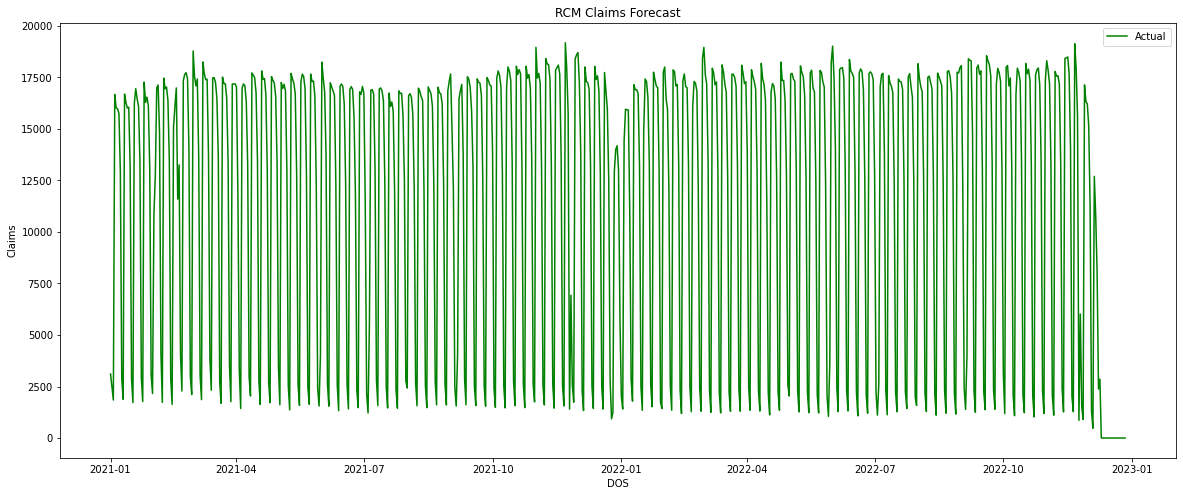

In [16]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(claim_data
         ,color='g', label='Actual')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [17]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [18]:
test_fc=test.reset_index()
test_fc.head()

,ds,y
0,2022-10-01,3089
1,2022-10-02,1185
2,2022-10-03,17997
3,2022-10-04,18075
4,2022-10-05,17080


In [19]:
train_fc=train.set_index('ds')#.loc['01-01-2020':]
train_fc=train_fc.reset_index()
train_fc.head()

,ds,y
0,2021-01-01,3110
1,2021-01-02,2496
2,2021-01-03,1844
3,2021-01-04,16669
4,2021-01-05,16021


### Hyperparameter Tuning

In [20]:
my_model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,)

In [21]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[10,15,20],
              'n_changepoints' : [25,50,75,100,125]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [22]:
future_dates=pd.DataFrame(test_fc['ds'])
future_dates
model_parameters = pd.DataFrame(columns = ['mape','me','rmse','Parameters'])
cnt=1
for p in grid:
    clear_output(wait=True)
    print('Running at: ',cnt)
    cnt+=1
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         holidays=holiday, 
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    train_forecast = train_model.predict(future_dates)
    fc=train_forecast[['ds','yhat']]
    me = me = np.mean(fc.yhat - test_fc.y)
    mape=np.mean(np.abs(fc.yhat - test_fc.y)/np.abs(test_fc.y)) 
    rmse=rmse = np.mean((fc.yhat - test_fc.y)**2)**.5
    model_parameters = model_parameters.append({'mape':mape,'me':me,'rmse':rmse,'Parameters':p},ignore_index=True)
    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Running at:  150


INFO:cmdstanpy:finish chain 1


In [23]:
md=model_parameters.copy()
md['me']=abs(md['me'])
md.sort_values(by=['rmse'],ascending=True).iloc[0]['Parameters']


{'changepoint_prior_scale': 0.2,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

In [24]:
#best rmse vale
{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

#best mape value
{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 10,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

my_model1 = Prophet(changepoint_prior_scale = 0.2,
                     holidays_prior_scale = 20,
                     n_changepoints = 100,
                     seasonality_mode = 'multiplicative',
                     weekly_seasonality=True,
#                      daily_seasonality=True,
#                      yearly_seasonality=True,
                     holidays=holiday,
                     interval_width=0.95)

In [25]:
my_model1.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [26]:
filename = 'RCM_Prophet_Overall_Billing_Claims.sav'
pickle.dump(my_model1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

date_range=pd.date_range(start = '09-01-2022', end = '12-15-2022')
future_dates=pd.DataFrame(date_range,columns=['ds'])


forecast_outsample = loaded_model.predict(future_dates)
forecast_outsample[['ds', 'yhat']].tail()

,ds,yhat
101,2022-12-11,1662.63786
102,2022-12-12,17682.23759
103,2022-12-13,17785.54020
104,2022-12-14,17660.39646
105,2022-12-15,17064.03513


In [27]:
test=claim_data.loc['09-01-2022':'12-15-2022']

future_dates=pd.DataFrame(test.reset_index()['ds'])
future_dates

date_range=pd.date_range(start = '09-01-2022', end = '12-15-2022')
fd=pd.DataFrame(date_range,columns=['ds'])
test.tail()

,y
ds,
2022-12-07,8043
2022-12-08,2378
2022-12-09,2856
2022-12-10,1
2022-12-15,1


In [28]:
forecast_outsample = my_model1.predict(fd)
forecast_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50)


,ds,yhat,yhat_lower,yhat_upper
0,2022-09-01,16958.31334,14402.64693,19672.51074
1,2022-09-02,13084.98711,10577.64481,15567.90017
2,2022-09-03,2766.53078,42.41579,5530.47373
3,2022-09-04,1653.02130,-1020.89419,4228.56815
4,2022-09-05,11790.08391,9280.62255,14474.71080
5,2022-09-06,17682.68225,14947.58582,20113.26015
6,2022-09-07,17558.26827,14882.92059,20328.45017
7,2022-09-08,16965.36146,14400.07625,19449.96622
8,2022-09-09,13090.42510,10658.35839,15631.00845
9,2022-09-10,2767.68046,193.50404,5354.32492


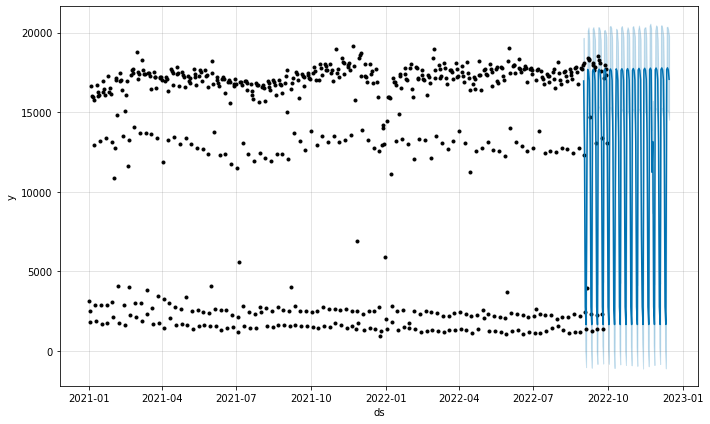

In [29]:
fig=my_model1.plot(forecast_outsample, uncertainty=True)

In [30]:
fc=forecast_outsample[['ds','yhat']]
fc.set_index('ds',inplace=True)
fc.head()

,yhat
ds,
2022-09-01,16958.31334
2022-09-02,13084.98711
2022-09-03,2766.53078
2022-09-04,1653.02130
2022-09-05,11790.08391


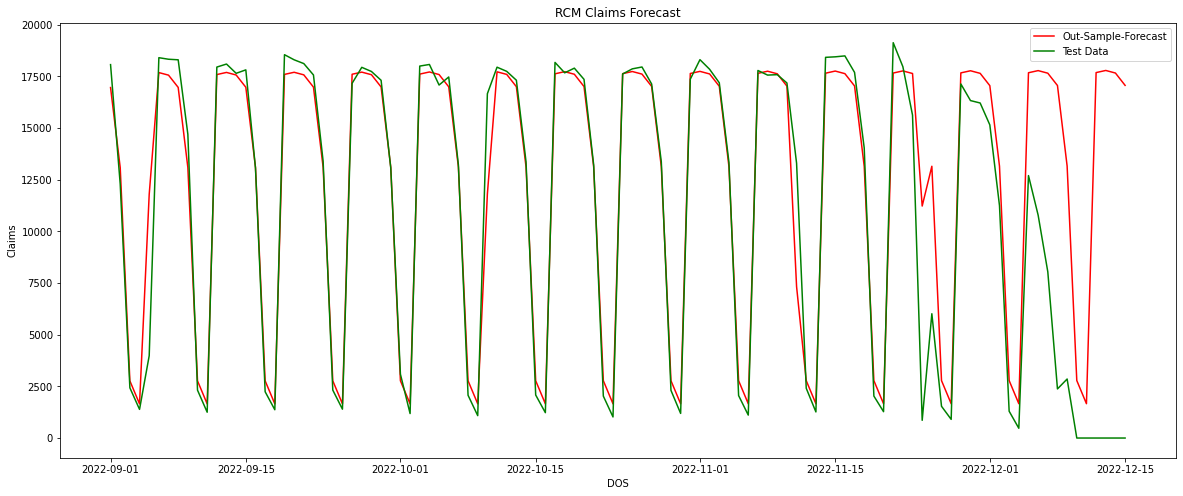

In [31]:
plt.rcParams["figure.figsize"] = (20,8)
#plt.plot(train.set_index('ds'),color='y', label='Train Data')
#plt.plot(tc,color='b', label='In-Sample-Forecast')
plt.plot(fc,color='r', label='Out-Sample-Forecast')
plt.plot(test,color='g', label='Test Data')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [32]:
# print('ME Out Sample Forecast: ',np.mean(fc.values-test.values))

# print('RMSE Out Sample Forecast: ',np.mean((fc.yhat - test.y)**2)**.5 )

# print('MAPE: ',np.mean(np.abs(fc.yhat - test.y)/np.abs(test.y)))

In [33]:
d=pd.merge(
    forecast_outsample[['ds', 'yhat']],
    test.reset_index(),
    how="left",
    on=['ds'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
d['diff']=abs(d['yhat']-d['y'])
#d.to_csv('prophet.csv')
d.head(50)

,ds,yhat,y,diff
0,2022-09-01,16958.31334,18068.00000,1109.68666
1,2022-09-02,13084.98711,12289.00000,795.98711
2,2022-09-03,2766.53078,2430.00000,336.53078
3,2022-09-04,1653.02130,1388.00000,265.02130
4,2022-09-05,11790.08391,3983.00000,7807.08391
5,2022-09-06,17682.68225,18403.00000,720.31775
6,2022-09-07,17558.26827,18328.00000,769.73173
7,2022-09-08,16965.36146,18301.00000,1335.63854
8,2022-09-09,13090.42510,14698.00000,1607.57490
9,2022-09-10,2767.68046,2317.00000,450.68046


In [34]:
predicted=d['yhat'].sum()
original=d['y'].sum()

print(predicted,original)


(original/predicted)*100
# (predicted/original)*100

1306906.8236875087 1166205.0


89.23398201483785

In [35]:
d.yhat = d.yhat.apply(int)

In [ ]:
# def DUMP_DATA(d,forecast_section,pracice_code):
#     data_to_dump=d[['yhat','ds']]
#     data_to_dump['PRACTICE_CODE']=pracice_code
#     data_to_dump['FORECAST_TYPE']=forecast_section
#     data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

#     con = pymssql.connect(user='mtbcweb',password = 'mtbcweb@mtbc'
#                          ,host='172.16.0.168',database='AmazingDb',autocommit = True)
#     cur=con.cursor()
#     for i, row in data_to_dump.iterrows():
#         query="""
#             insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
#         values(%s,%s,%s,%s)
#             """
#         cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
#     print('Data Inserted')
#     con.close()

In [ ]:
# def DUMP_DATA(d,forecast_section,pracice_code):
#     data_to_dump=d[['yhat','ds']]
#     data_to_dump['PRACTICE_CODE']=pracice_code
#     data_to_dump['FORECAST_TYPE']=forecast_section
#     data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

#     con = pymssql.connect(user='datascience',password = 'mtbc@1234'
#                          ,host='172.16.0.66',database='ds_test',autocommit = True)
#     cur=con.cursor()
#     for i, row in data_to_dump.iterrows():
#         query="""
#             insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
#         values(%s,%s,%s,%s)
#             """
#         cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
#     print('Data Inserted')
#     con.close()

In [ ]:
# DUMP_DATA(d,'Overall_Billing_Claims', 0)